# Importing all the necessary libraries

In [1]:
import cv2
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

C:\Users\local_psxaa551\Temp\ipykernel_16848\3150294456.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# Loading the Dataset

In [2]:
import numpy as np
from matplotlib import pyplot as plt
data = tf.keras.preprocessing.image_dataset_from_directory(
    "Binary_Data",
    shuffle=True,
    image_size=(224,224),
    batch_size=32)

Found 8846 files belonging to 2 classes.


In [3]:
class_names = data.class_names
class_names

['biodegradable', 'non_biodegradable']

# Displaying sample images 

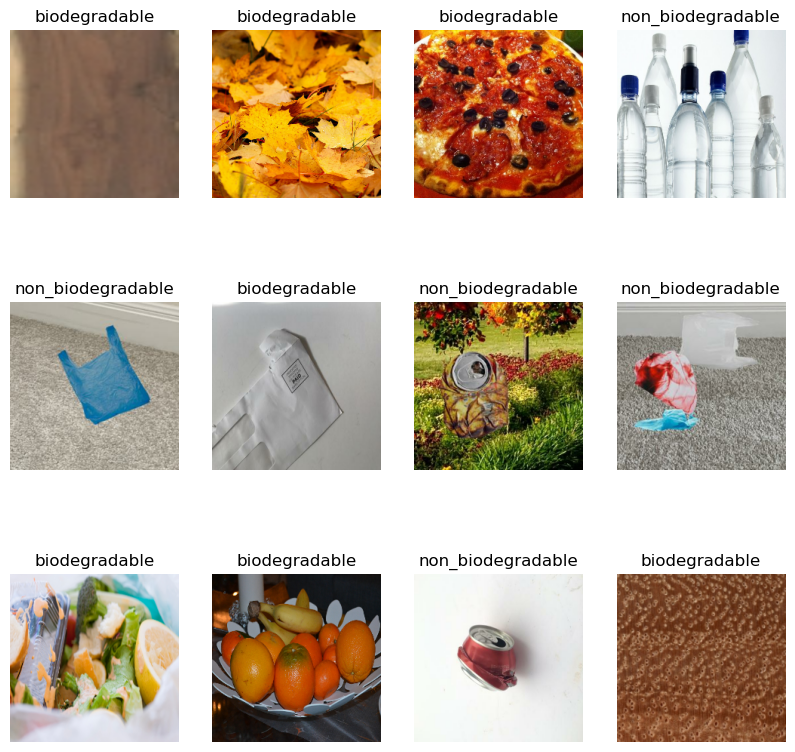

In [4]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Splitting the Dataset into training, testing and validation splits

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data)

# Caching and shuffling the Datasets

In [6]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Preprocessing

## Rescaling:

In [7]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255),
])

## Data Augmentation:

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
  layers.RandomZoom(height_factor=0.3, width_factor=0.3),
])

### Displaying the augmentated images:

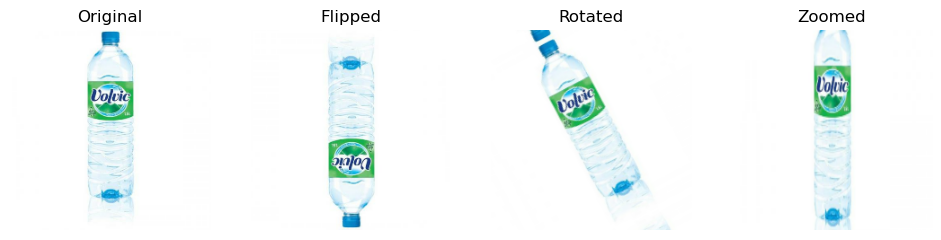

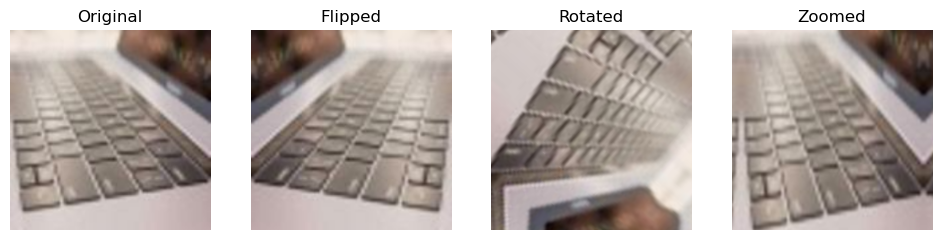

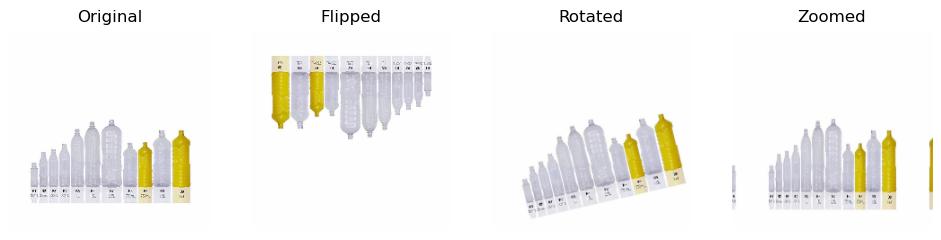

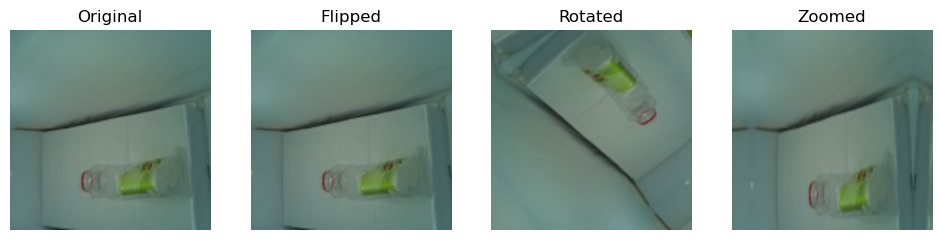

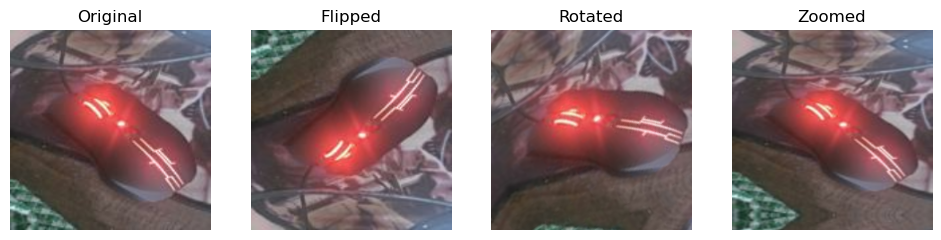

In [9]:
random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
random_rotation = tf.keras.layers.RandomRotation(0.4)
random_zoom = tf.keras.layers.RandomZoom(height_factor=0.3, width_factor=0.3)  # Random zoom layer

# Takes a single batch of images from the dataset
for images, labels in train_ds.take(1):  # Take one batch
    for i in range(5):  # Display 5 images with their augmentations
        original_image = images[i]
        
        # Applying the augmentations separately
        flipped_image = random_flip(tf.expand_dims(original_image, 0))  # Apply random flip
        rotated_image = random_rotation(tf.expand_dims(original_image, 0))  # Apply random rotation
        zoomed_image = random_zoom(tf.expand_dims(original_image, 0))  # Apply random zoom
        
        # Plotting original and augmented images side by side
        plt.figure(figsize=(15, 3))
        
        # Displays original image
        plt.subplot(1, 5, 1)
        plt.imshow(original_image.numpy().astype("uint8"))
        plt.title("Original")
        plt.axis('off')
        
        # Displays flipped image
        plt.subplot(1, 5, 2)
        plt.imshow(tf.squeeze(flipped_image).numpy().astype("uint8"))
        plt.title("Flipped")
        plt.axis('off')
        
        # Displays rotated image
        plt.subplot(1, 5, 3)
        plt.imshow(tf.squeeze(rotated_image).numpy().astype("uint8"))
        plt.title("Rotated")
        plt.axis('off')
        
        # Displays zoomed image
        plt.subplot(1, 5, 4)
        plt.imshow(tf.squeeze(zoomed_image).numpy().astype("uint8"))
        plt.title("Zoomed")
        plt.axis('off')
        
        plt.show()


### Mapping the augmentation to the training dataset:

In [10]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building and Training

## Model Architecture:

In [11]:
model = models.Sequential([
    rescale,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu',padding = 'same', input_shape=(32,224,224,3)),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128,  kernel_size = (3,3), activation='relu',padding = 'same'),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256,  kernel_size = (3,3), activation='relu',padding = 'same'),

    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(512,  kernel_size = (3,3), activation='relu',padding = 'same'),

    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),    
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03)),
    layers.Dropout(0.5),   

    
    layers.Dense(1, activation='sigmoid'),
])

model.build(input_shape=(32,224,224,3))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 224, 224, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 112, 112, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 112, 112, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 56, 56, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 56, 56, 256)        

## Implemeting EarlyStopping:

In [13]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

## Compiling the model:

In [14]:
initial_learning_rate = 0.00001
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)

In [15]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Training the model
history = model.fit(train_ds, epochs=100, batch_size=32, verbose=1, validation_data=val_ds,callbacks = callback)

Epoch 1/100
221/221 [==============================] - 1071s 5s/step - loss: 21.7089 - accuracy: 0.6534 - val_loss: 14.2066 - val_accuracy: 0.7512
Epoch 2/100
221/221 [==============================] - 1080s 5s/step - loss: 9.8188 - accuracy: 0.7624 - val_loss: 6.4141 - val_accuracy: 0.8194
Epoch 3/100
221/221 [==============================] - 1073s 5s/step - loss: 4.4971 - accuracy: 0.8079 - val_loss: 2.9915 - val_accuracy: 0.8356
Epoch 4/100
221/221 [==============================] - 1050s 5s/step - loss: 2.1979 - accuracy: 0.8100 - val_loss: 1.5522 - val_accuracy: 0.8380
Epoch 5/100
221/221 [==============================] - 1042s 5s/step - loss: 1.2390 - accuracy: 0.8126 - val_loss: 0.9563 - val_accuracy: 0.8345
Epoch 6/100
221/221 [==============================] - 1052s 5s/step - loss: 0.8307 - accuracy: 0.8176 - val_loss: 0.7160 - val_accuracy: 0.8171
Epoch 7/100
221/221 [==============================] - 1084s 5s/step - loss: 0.6530 - accuracy: 0.8174 - val_loss: 0.5837 - val_

## Plotting the Accuracy and Loss Curves

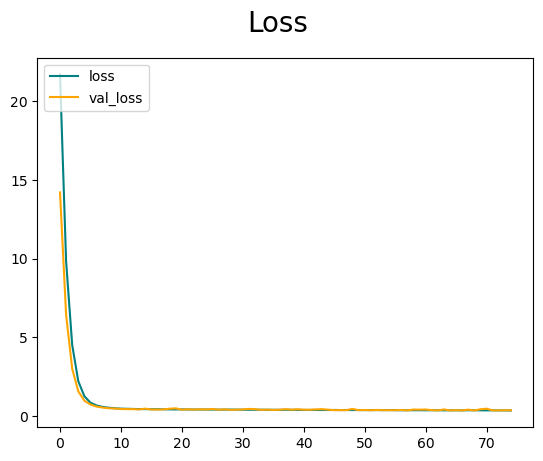

In [17]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

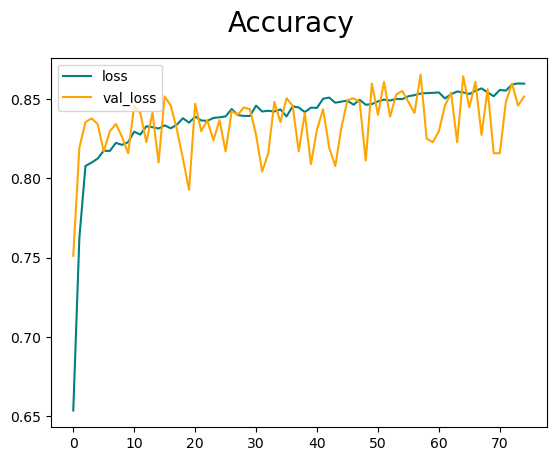

In [18]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='loss')
plt.plot(history.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Saving the model

In [19]:
model.save('binary_model.h5')

C:\Anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
